<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_portfolio_allocation_NeurIPS_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-h57tdpgx
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-h57tdpgx
     |████████████████████████████████| 153kB 6.0MB/s 
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-v_8pc1pt/pyfolio
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-v_8pc1pt/pyfolio
     |████████████████████████████████| 5.5MB 5.6MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
  Created wheel for finrl: filename=finrl-0.0.3-cp37-none-any.whl size=38201 sha256=32daefc16d75512e245bae290ecbcef609308f7e72e8c703912090ab681966f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-c79wlb1o/wheels/9c/19/bf/c644def96612df1ad42c94d5304966797eaa3221dffc5efe0b
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=33e844557fd830176260eb1fc0bbbad4a9efeb348e70b2385e08bd158d638cfa
  


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_portfolio import StockPortfolioEnv

from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

import sys
sys.path.append("../FinRL-Library")

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [7]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [4]:
df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [9]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2008-01-02,7.116786,7.152143,6.876786,5.993858,1079178800,AAPL,2
1,2008-01-02,52.090000,52.320000,50.790001,41.025105,8053700,AXP,2
2,2008-01-02,87.570000,87.839996,86.000000,63.481632,4303000,BA,2
3,2008-01-02,72.559998,72.669998,70.050003,48.370781,6337800,CAT,2
4,2008-01-02,27.000000,27.299999,26.209999,19.847456,64338900,CSCO,2


In [5]:
df.shape

(98167, 8)

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [5]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [7]:
df.shape

(90660, 17)

In [8]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list
0,2008-12-31,3.070357,3.133571,3.047857,2.625620,607541200,AAPL,2,0.112284,53.286016,47.561928,48.009267,25.841124,5.858025,50.614908,50.970387,"[[0.0014139107044444073, 0.0011800730357944612..."
1,2008-12-31,17.969999,18.750000,17.910000,15.110051,9625600,AXP,2,0.225512,53.469344,47.791641,51.045341,80.048691,0.220406,50.690795,50.894582,"[[0.0014139107044444073, 0.0011800730357944612..."
2,2008-12-31,41.590000,43.049999,41.500000,32.005901,5443100,BA,2,0.322032,53.717290,47.766477,51.269660,96.444709,2.969231,50.754757,50.823502,"[[0.0014139107044444073, 0.0011800730357944612..."
3,2008-12-31,43.700001,45.099998,43.700001,31.403988,6277400,CAT,2,0.327176,53.791300,47.768897,49.751662,71.687120,0.296878,50.778336,50.740350,"[[0.0014139107044444073, 0.0011800730357944612..."
4,2008-12-31,16.180000,16.549999,16.120001,12.189656,37513700,CSCO,2,0.511681,54.318893,47.618570,53.664757,172.384973,17.964888,50.874008,50.731082,"[[0.0014139107044444073, 0.0011800730357944612..."


## Add covariance matrix as states

In [6]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  covs = return_lookback.cov().values 
  cov_list.append(covs)
  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)
        

In [17]:
df.shape

(90660, 17)

In [19]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list
0,2008-12-31,3.070357,3.133571,3.047857,2.625620,607541200,AAPL,2,0.112284,53.286016,47.561928,48.009267,25.841124,5.858025,50.614908,50.970387,"[[0.0014139107044444073, 0.0011800730357944612..."
1,2008-12-31,17.969999,18.750000,17.910000,15.110051,9625600,AXP,2,0.225512,53.469344,47.791641,51.045341,80.048691,0.220406,50.690795,50.894582,"[[0.0014139107044444073, 0.0011800730357944612..."
2,2008-12-31,41.590000,43.049999,41.500000,32.005901,5443100,BA,2,0.322032,53.717290,47.766477,51.269660,96.444709,2.969231,50.754757,50.823502,"[[0.0014139107044444073, 0.0011800730357944612..."
3,2008-12-31,43.700001,45.099998,43.700001,31.403988,6277400,CAT,2,0.327176,53.791300,47.768897,49.751662,71.687120,0.296878,50.778336,50.740350,"[[0.0014139107044444073, 0.0011800730357944612..."
4,2008-12-31,16.180000,16.549999,16.120001,12.189656,37513700,CSCO,2,0.511681,54.318893,47.618570,53.664757,172.384973,17.964888,50.874008,50.731082,"[[0.0014139107044444073, 0.0011800730357944612..."


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2018-12-31

In [9]:
train = data_split(df, '2009-01-01','2019-01-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)

In [11]:
train.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list
0,2009-01-02,3.067143,3.251429,3.041429,2.791740,746015200,AAPL,4,0.916411,58.037324,50.483560,58.279413,231.362748,28.830569,53.921125,52.268017,"[[0.001427708918378416, 0.0011886537539480882,..."
0,2009-01-02,18.570000,19.520000,18.400000,15.745411,10955700,AXP,4,1.104879,58.632931,50.354922,57.951206,206.221389,31.974391,54.109576,52.400186,"[[0.001427708918378416, 0.0011886537539480882,..."
0,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4,1.225587,59.109112,50.287868,57.599664,171.846491,31.974391,54.287689,52.521223,"[[0.001427708918378416, 0.0011886537539480882,..."
0,2009-01-02,44.910000,46.980000,44.709999,32.978760,7117200,CAT,4,1.288569,59.477777,50.242415,57.159546,138.088204,22.759063,54.486354,52.632345,"[[0.001427708918378416, 0.0011886537539480882,..."
0,2009-01-02,16.410000,17.000000,16.250000,12.683227,40980600,CSCO,4,1.295162,59.737547,50.442506,56.448825,117.945877,22.759063,54.596320,52.735164,"[[0.001427708918378416, 0.0011886537539480882,..."


## Environment for Portfolio Allocation


In [12]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [13]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 30


In [14]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [15]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [16]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [17]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [18]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=60000)

Logging to tensorboard_log/a2c/a2c_1
------------------------------------
| time/                 |          |
|    fps                | 132      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | -2.1e+16 |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 2.02e+08 |
|    std                | 0.999    |
|    value_loss         | 2.51e+13 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 168       |
|    iterations         | 200       |
|    time_elapsed       | 5         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -42.5     |
|    explained_variance | -1.37e+14 |
|    learning_rate      | 0.0002    |
|    n_updates          | 19

### Model 2: **PPO**


In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=80000)

Logging to tensorboard_log/ppo/ppo_3
-----------------------------
| time/              |      |
|    fps             | 458  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
begin_total_asset:1000000
end_total_asset:4917364.6278486075
Sharpe:  1.074414829116363
--------------------------------------------
| time/                   |                |
|    fps                  | 391            |
|    iterations           | 2              |
|    time_elapsed         | 10             |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | -7.8231096e-08 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -42.6          |
|    explained_variance   | -3.71e+14      |
|    learning_rate        | 0.0001         |
|    loss                 | 7.78e+14       |
|    n_updates            | 10     

### Model 3: **DDPG**


In [ ]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

Logging to tensorboard_log/ddpg/ddpg_2
begin_total_asset:1000000
end_total_asset:4625995.900359718
Sharpe:  1.040202670783119
begin_total_asset:1000000
end_total_asset:4450723.86820311
Sharpe:  1.008267759668747
begin_total_asset:1000000
end_total_asset:4450723.86820311
Sharpe:  1.008267759668747
begin_total_asset:1000000
end_total_asset:4450723.86820311
Sharpe:  1.008267759668747
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 22        |
|    time_elapsed    | 439       |
|    total timesteps | 10064     |
| train/             |           |
|    actor_loss      | -6.99e+07 |
|    critic_loss     | 7.27e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 7548      |
----------------------------------
begin_total_asset:1000000
end_total_asset:4450723.86820311
Sharpe:  1.008267759668747
begin_total_asset:1000000
end_total_asset:4450723.86820311
Sharpe:  1.008267759668747
begin_total_asset:100000

### Model 4: **SAC**


In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000)

Logging to tensorboard_log/sac/sac_1
begin_total_asset:1000000
end_total_asset:4449463.498168942
Sharpe:  1.01245667390232
begin_total_asset:1000000
end_total_asset:4418643.239765096
Sharpe:  1.0135796594260282
begin_total_asset:1000000
end_total_asset:4418644.1960784905
Sharpe:  1.0135797537524718
begin_total_asset:1000000
end_total_asset:4418659.429680678
Sharpe:  1.013581852537709
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 12        |
|    time_elapsed    | 783       |
|    total timesteps | 10064     |
| train/             |           |
|    actor_loss      | -8.83e+07 |
|    critic_loss     | 6.57e+12  |
|    ent_coef        | 2.24      |
|    ent_coef_loss   | -205      |
|    learning_rate   | 0.0003    |
|    n_updates       | 9963      |
----------------------------------
begin_total_asset:1000000
end_total_asset:4418651.576406099
Sharpe:  1.013581224026754
begin_total_asset:1000000
end_total_

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

In [19]:
trade = data_split(df,'2019-01-01', '2021-01-01')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


In [20]:
trade.shape

(15150, 17)

In [21]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1378479.3153582362
Sharpe:  0.7256224269747727
hit end!


In [22]:
df_daily_return.head()

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.026070
2,2019-01-04,0.030651
3,2019-01-07,0.003244
4,2019-01-08,0.010173


In [23]:
df_actions.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
2019-01-03,0.043177,0.023067,0.023067,0.023067,0.023067,0.049363,0.023067,0.062702,0.040105,0.062702,0.062702,0.023067,0.023067,0.024081,0.023067,0.023468,0.034505,0.023067,0.023067,0.062702,0.023067,0.023067,0.037900,0.041218,0.045544,0.023067,0.025558,0.029885,0.023067,0.031449
2019-01-04,0.041439,0.022434,0.022434,0.043047,0.026222,0.060981,0.022434,0.022434,0.022434,0.060981,0.023990,0.022434,0.060981,0.026523,0.022434,0.036422,0.042220,0.022434,0.022434,0.023295,0.048187,0.022434,0.041442,0.028237,0.022434,0.022434,0.060981,0.060981,0.022434,0.022434
2019-01-07,0.022466,0.022466,0.022466,0.061068,0.022466,0.022466,0.022466,0.048714,0.043475,0.034668,0.061068,0.022466,0.022466,0.061068,0.061068,0.022466,0.022466,0.040837,0.037356,0.028510,0.033452,0.022466,0.034082,0.022466,0.029013,0.025082,0.061068,0.022466,0.022466,0.024953
2019-01-08,0.059374,0.021843,0.022978,0.032948,0.021843,0.021843,0.052337,0.025369,0.021843,0.040837,0.059374,0.027415,0.021843,0.059374,0.021843,0.021843,0.025251,0.059374,0.021843,0.021843,0.043727,0.021843,0.044417,0.021843,0.021843,0.030729,0.050114,0.023052,0.021843,0.059374


In [24]:
df_actions.to_csv('df_actions.csv')

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [25]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [26]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.173714
Cumulative returns      0.378479
Annual volatility       0.271792
Sharpe ratio            0.725622
Calmar ratio            0.513842
Stability               0.358872
Max drawdown           -0.338068
Omega ratio             1.170266
Sortino ratio           1.032237
Skew                   -0.181606
Kurtosis               13.165751
Tail ratio              0.855595
Daily value at risk    -0.033460
Alpha                   0.000000
Beta                    1.000000
dtype: float64

<a id='6.2'></a>
## 7.2 BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,17.371%
Cumulative returns,37.848%
Annual volatility,27.179%
Sharpe ratio,0.73
Calmar ratio,0.51
Stability,0.36
Max drawdown,-33.807%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.81,2020-02-12,2020-03-23,2020-09-02,146
1,9.18,2020-09-02,2020-10-28,2020-11-09,49
2,6.99,2019-04-23,2019-05-31,2019-06-20,43
3,6.65,2019-07-29,2019-08-14,2019-09-11,33
4,4.53,2019-09-13,2019-10-02,2019-10-30,34


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


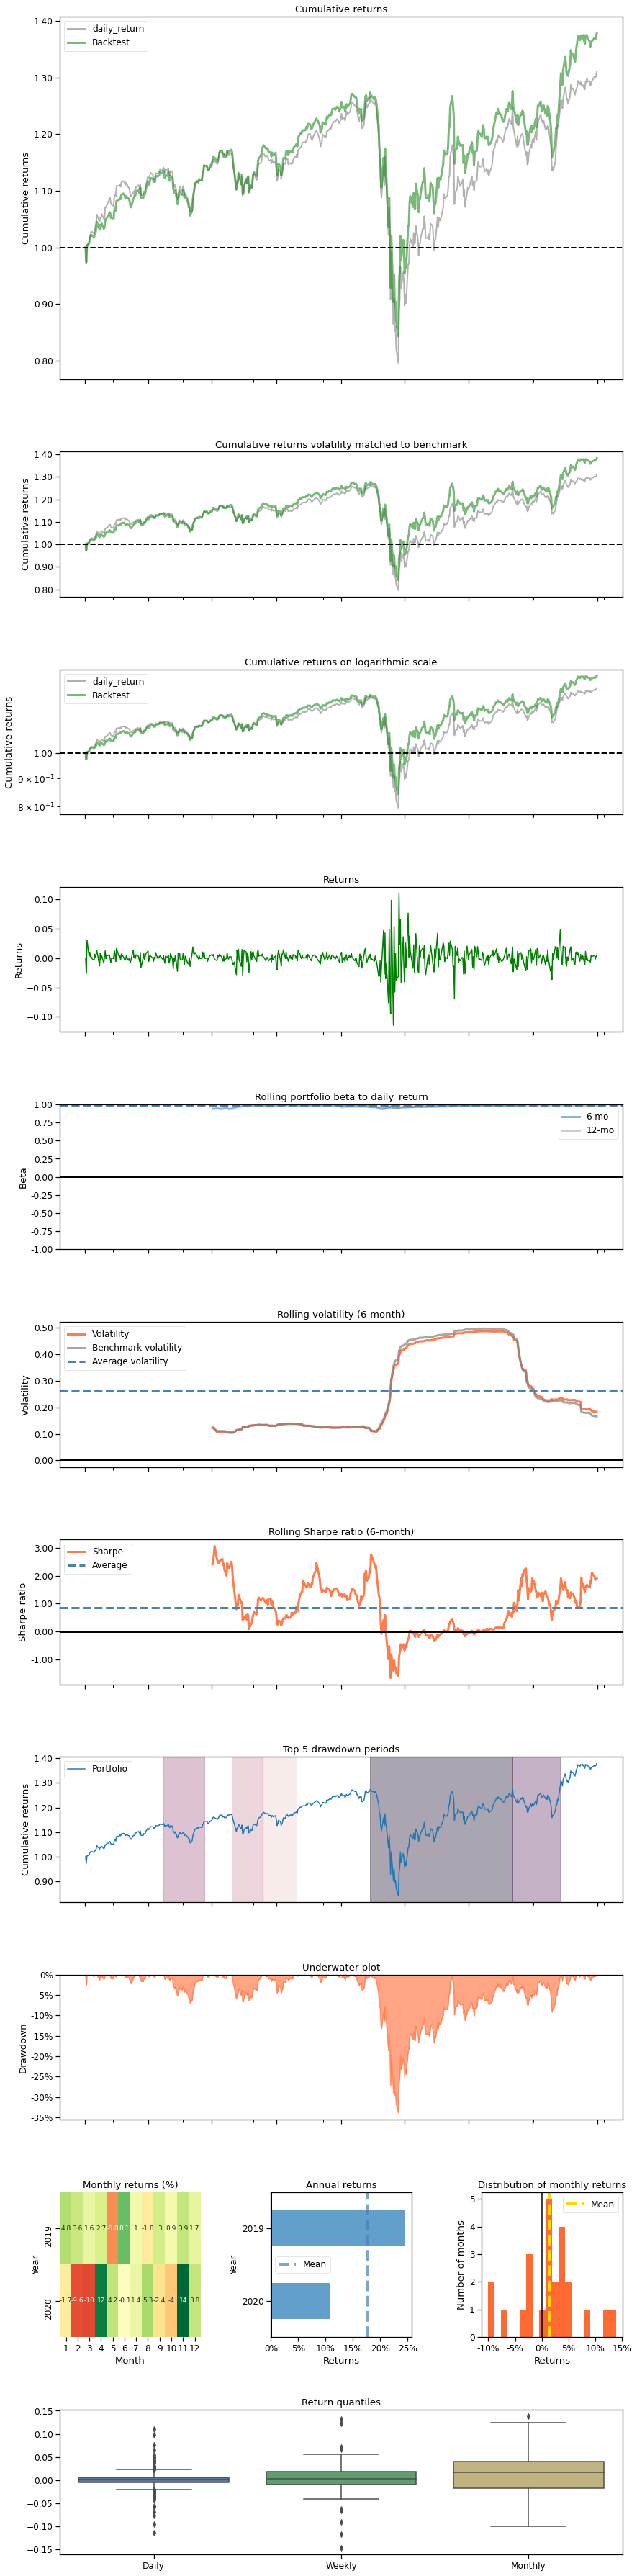

In [28]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)